In [2]:
%load_ext autoreload

In [3]:
autoreload 2

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import sympy as sym

import inputs
import models
import shooting

from __future__ import division

In [31]:
# define some default workers skill
x, mu1, sigma1 = sym.var('x, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'mu1': 4.12, 'sigma1': 0.56}
skill_bounds = [60.0, 179.9]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some default firms
y, mu2, sigma2 = sym.var('y, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'mu2': 10.5328 , 'sigma2': 0.9759}
productivity_bounds = [0.6347540, 3700.0]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for Cobb-Douglas between l and r
l, r, omega_B, sigma_B = sym.var('l, r, omega_B, sigma_B')
B = l**omega_B * r**(1 - omega_B)

F = A * B

F_params = {'omega_A':0.75, 'omega_B':0.25, 'sigma_A':0.6, 'sigma_B':1.0}

model = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = shooting.ShootingSolver(model=model)

## Solving the model given the parameters supplied

In [7]:
import solve_model2 as solve_model

In [9]:
Est_Dis = solve_model.Solve_Model(F, F_params, workers, firms, 'positive', 100, 'vode', 2500)

AssertionError: Upper and lower bounds are identical: check solver tols!

In [113]:
shape_f, loc_f, scale_f = Est_Dis[0]
shape_w, loc_w, scale_w = Est_Dis[1]

In [114]:
shape_f, loc_f, scale_f

(2.5688520186467199, 0.01859467432638276, 0.019793669184174058)

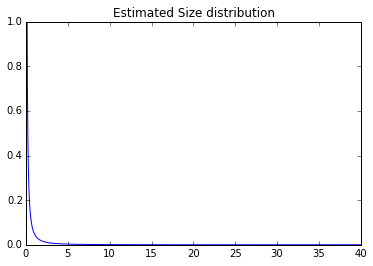

In [116]:
size_range = np.arange(0, 100, 0.01)
size_hat = stats.lognorm.pdf(size_range, s=shape_f, loc=loc_f, scale=scale_f)
plt.plot(size_range, size_hat)
plt.ylim(0,1)
plt.xlim(0,40)
plt.title('Estimated Size distribution')
plt.show()

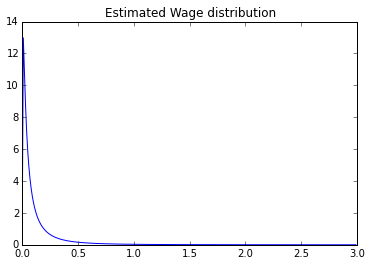

In [117]:
w_range = np.arange(0, 3.0, 0.01)
wage_hat = stats.lognorm.pdf(w_range, s=shape_w, loc=loc_w, scale=scale_w)
plt.plot(w_range, wage_hat)
plt.title('Estimated Wage distribution')
plt.show()

## Calculating MSE

In [120]:
import load_data as d
data_points  = (d.size, d.wage)
data_param = (stats.lognorm.fit(d.size), stats.lognorm.fit(d.wage))
model_param = (Est_Dis[0], Est_Dis[1])

In [123]:
solve_model.Calculate_MSE_pdf(data_points, data_param, model_param, 'lognormal')

(3.564556602031435, 1.8016448056880114)

In [125]:
solve_model.Calculate_MSE_cdf(data_points, data_param, model_param, 'lognormal')

(2634.0464937185634, 3273.0107221036856)

## Iterate for some parameters

In [134]:
om = 0.65
results_i = []
for i in range(7):
    om -= 0.05
    if om > 0.5:
        params_i = {'omega_A':0.75, 'omega_B':0.25, 'sigma_A':om, 'sigma_B':1.0}
        Est_Dis = solve_model.Solve_Model(F, params_i, workers, firms, 'positive', 100, 'vode', 2e3)
        model_param = (Est_Dis[0], Est_Dis[1])
        results_i.append(solve_model.Calculate_MSE_pdf(data_points, data_param, model_param, 'lognormal'))
    else:
        params_i = {'omega_A':0.75, 'omega_B':0.25, 'sigma_A':om, 'sigma_B':1.0}
        Est_Dis = solve_model.Solve_Model(F, params_i, workers, firms, 'positive', 100, 'vode', 2e4)
        model_param = (Est_Dis[0], Est_Dis[1])
        results_i.append(solve_model.Calculate_MSE_pdf(data_points, data_param, model_param, 'lognormal'))
results_i

Success! All workers and firms are matched
Success! All workers and firms are matched
Success! All workers and firms are matched
Success! All workers and firms are matched
Success! All workers and firms are matched
Success! All workers and firms are matched
Success! All workers and firms are matched


[(3.564556602031435, 1.8016448056880114),
 (3.5130386421457178, 1.8024263418905722),
 (3.6644913045037208, 1.7993633737288333),
 (4.1786800635414689, 1.7985190072067558),
 (13.762594699811459, 1.7978552228615967),
 (24.41345421208003, 1.797350048455717),
 (44.25661771832609, 1.7969785206138693)]

## Results from estimation

In [97]:
solver.solve(0.001, tol=1e-5, number_knots=2000, atol=1e-15, rtol=1e-12, integrator='vode', message=False)

In [98]:
solver.solution

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
179.893227,785.811333,0.000431,19399.315930,25.094074
179.900000,3700.000000,0.000500,19402.083577,29.103125


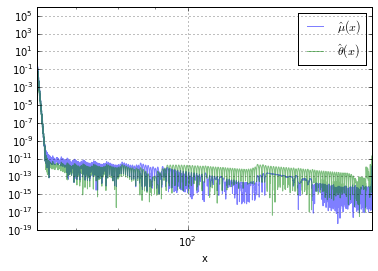

In [96]:
solver.residuals.plot(loglog=True, alpha=0.5)
plt.show()

In [69]:
x = solver.solution.index.values
mus = solver.solution['$\\mu(x)$'].values
thetas = solver.solution['$\\theta(x)$'].values
ws = solver.solution['$w(x)$'].values

''' 4.Interpolate the other way round (y(theta), y(wages)) '''
basePol1 = solve_model.polynomial_factory(4000, "Chebyshev", [firms.lower, firms.upper])
basePol2 = solve_model.polynomial_factory(4000, "Chebyshev", [firms.lower, firms.upper])
y_theta = basePol1.fit(thetas[1:], mus[1:], 4000)
y_wage = basePol2.fit(ws[1:], mus[1:], 4000)

In [70]:
t_step = (max(thetas[1:])-min(thetas))/100.0
w_step = (max(ws[1:])-min(ws))/100.0
theta_range = np.arange(min(thetas), max(thetas[1:]), t_step)
w_range = np.arange(min(ws), max(ws[1:]), w_step)

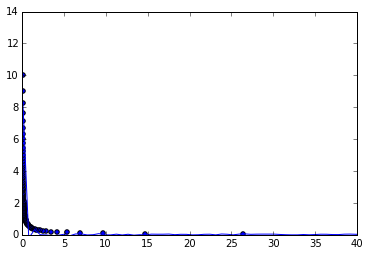

In [97]:
plt.plot(theta_range, y_theta(theta_range))
plt.scatter(thetas[1:],mus[1:])
plt.xlim(0,40)
plt.ylim(0,14)
plt.show()

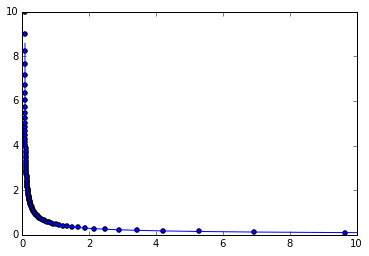

In [119]:
from scipy.interpolate import InterpolatedUnivariateSpline
sateht = thetas[::-1]
sums = mus[::-1]
y_spl = InterpolatedUnivariateSpline(thetas[::-1], mus[::-1], k=5)
plt.plot(thetas, y_spl(thetas))
plt.scatter(thetas[1:],mus[1:])
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

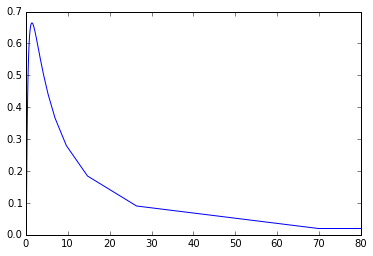

In [118]:
plt.plot(thetas, firms.evaluate_pdf(y_spl(thetas)))
#plt.scatter(thetas[1:],mus[1:])
plt.xlim(0,80)
#plt.ylim(0,10)
plt.show()

In [90]:
firms.evaluate_pdf(0.00001)

6.6565290616560284e-25

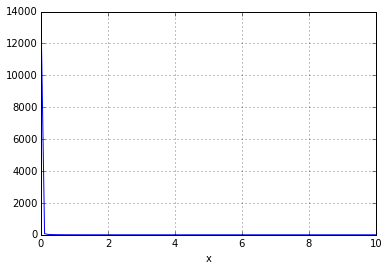

In [39]:
solver.solution['$\\theta(x)$'].plot()
plt.show()

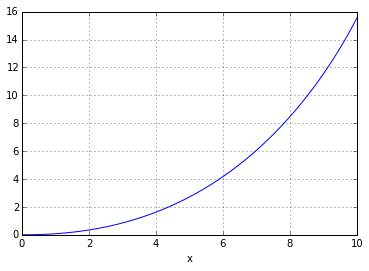

In [40]:
solver.solution['$w(x)$'].plot()
plt.show()

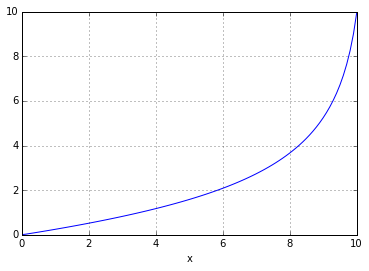

In [41]:
solver.solution['$\mu(x)$'].plot()
plt.show()

In [57]:
type(solver.solution['$\\theta(x)$'])

pandas.core.series.Series

In [60]:
a= np.asarray(solver.solution['$\\theta(x)$'])
a

array([  5.97469058e+19,   6.75588579e+10,   1.19441081e+10, ...,
         5.00203509e+01,   5.00101739e+01,   5.00000000e+01])